# LSTM Classifier

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.5 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 366 kB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 454.3 MB 31 kB/s s eta 0:00:01   |                                | 1.5 MB 13.9 MB/s eta 0:00:33
     |████████████████████████████████| 12.8 MB 33.0 MB/s eta 0:00:01
     |████████████████████████████████| 633 kB 44.7 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 42.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 98 kB/s s eta 0:00:01
     |████████████████████████████████| 6.0 MB 35.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 41.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 47.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████

In [1]:
import pandas as pd
import json
import urllib
import pandas as pd
import io
import os
import math
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import keras
from keras import backend as K

from matplotlib import pyplot as plt
from keras import Input
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional, concatenate, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
# from keras.tfa.metrics import F1Score
from collections import Counter, defaultdict
import spacy
from sklearn.preprocessing import StandardScaler
import numpy as np
import re
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from collections import Counter, defaultdict

### Customized Evaluation Functions

In [6]:
def f1(y_true, y_pred):
    y_true = float(y_true)
    y_pred = float(y_pred)
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def f1_loss(y_true, y_pred):
    y_true = float(y_true)
    y_pred = float(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1- K.mean(f1)

def f1_weighted_loss(true, pred): #shapes (batch, 4)
    true = float(true)
    pred = float(pred)
    ground_positives = K.sum(true, axis=0) + K.epsilon()
    pred_positives = K.sum(pred, axis=0) + K.epsilon()
    true_positives = K.sum(true * pred, axis=0) + K.epsilon() 
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)
    return 1 - weighted_f1

------------------------------------------------------------
Initializing LSTM Classifier
------------------------------------------------------------
Tokenizing Train


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


------------------------------------------------------------
Number of layer: 3
Batch-Size: 250
Node: [246, 123]
------------------------------------------------------------
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 146)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 146, 100)     828900      words[0][0]                      
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 146, 200)     160800      embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_17 

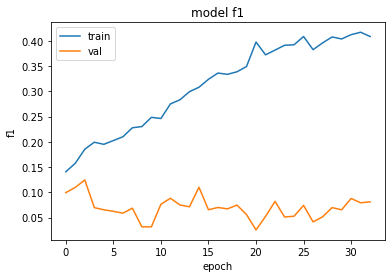

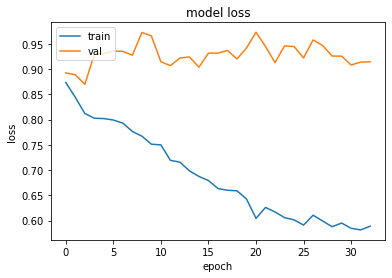

------------------------------------------------------------
Number of layer: 3
Batch-Size: 250
Node: [246, 75]
------------------------------------------------------------
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 146)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 146, 100)     828900      words[0][0]                      
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 146, 200)     160800      embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_19 (

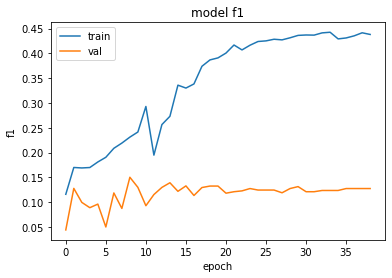

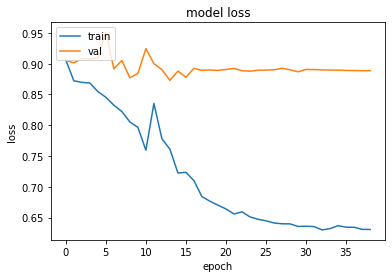

------------------------------------------------------------
Number of layer: 3
Batch-Size: 250
Node: [123, 75]
------------------------------------------------------------
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 146)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 146, 100)     828900      words[0][0]                      
__________________________________________________________________________________________________
bidirectional_20 (Bidirectional (None, 146, 200)     160800      embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_21 

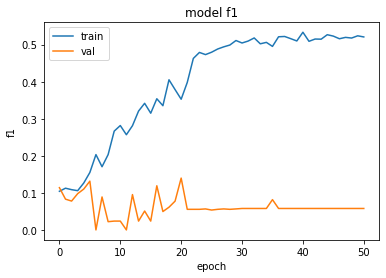

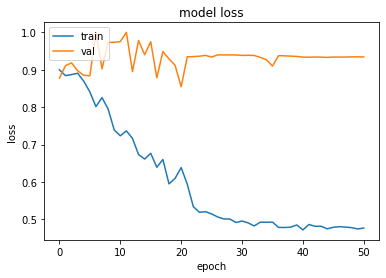

------------------------------------------------------------
Number of layer: 4
Batch-Size: 250
Node: [246, 123, 75]
------------------------------------------------------------
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 146)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 146, 100)     828900      words[0][0]                      
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, 146, 200)     160800      embedding_11[0][0]               
__________________________________________________________________________________________________
bidirectiona

In [ ]:
class LSTM_classifier:

    def __init__(self, df_train, df_validation, df_test,  mute = False):
        print("-"*60)
        print(f"Initializing LSTM Classifier")
        self.df_train = df_train
        self.df_validation = df_validation
        self.df_test = df_test
        self.benchmark_model = {"f1_val" : 0}
        self.gridsearch_models = pd.DataFrame(columns=['num_layers','batch_size','nodes','f1',"seed"])
        
        # Estimate LSTM-Model
        self.get_variables()
        self.fit_tokenize()
        self.Xvalidate_features, self.Xvalidate_words = self.tokenize(self.Xvalidate)
        self.Xtest_features, self.Xtest_words = self.tokenize(self.Xtest)
        self.mute = mute
        self.train_functional() #RUN functional
        
        # Evaluation on Test-Sample
        self.evaluate()

    # Definition of Auxiliary Function

    def get_variables(self):
        '''
        Get independent and dependent variable.
        '''
        drop_list = ['class', "game", 'receiver_labels',"absolute_message_index",'relative_message_index']
        drop_list += list(df_test.columns[-17:-3])
        indep_variables = list(filter(lambda x: x not in drop_list, df_test.columns))

        self.Xtrain, self.ytrain = self.df_train[indep_variables],  self.df_train['class'].astype('float32')
        self.Xvalidate, self.yvalidate = self.df_validation[indep_variables],  self.df_validation['class'].astype('float32')
        self.Xtest, self.ytest = self.df_test[indep_variables],  self.df_test['class'].astype('float32')
        self.ytrain = abs(self.ytrain - 1).astype('float32')
        self.ytest = abs(self.ytest - 1).astype('float32')
        self.yvalidate = abs(self.yvalidate - 1).astype('float32')



    def fit_tokenize(self):
        '''
        Build tokenize with training set
        '''
        print("-"*60)
        print(f"Tokenizing Train")
            
        # The maximum number of words to be used. (most frequent)
        self.MAX_NB_WORDS = 8000
        self.tokenizer = Tokenizer(num_words=self.MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        self.Xtrain.loc[:,'messages'] = self.Xtrain['messages'].astype(str)
        self.tokenizer.fit_on_texts(self.Xtrain['messages'].values)
        X = self.tokenizer.texts_to_sequences(self.Xtrain['messages'].values)
        self.max_sequence = max(len(seq) for seq in X)
        
        X = pad_sequences(X, maxlen=self.max_sequence)

        self.Xtrain_features = self.Xtrain.drop(columns=['messages'])
        self.Xtrain_words = pd.concat([pd.DataFrame(X)], axis=1)
    

    def tokenize(self, df):
        '''
        Tokenize messages input messages according to training's set vocabulary
        '''
        df.loc[:, 'messages'] = df['messages'].astype(str)
        X = self.tokenizer.texts_to_sequences(df['messages'].values)
        
        X = pad_sequences(X, maxlen=self.max_sequence)

        df_features = df.drop(columns=['messages'])
        df_words = pd.DataFrame(X)
        return df_features, df_words


    def glove(self, EMBEDDING_DIM):
        embeddings_index = {}
        f = open(os.path.join('glove.6B.100d.txt'))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        embedding_matrix = np.zeros((len(self.tokenizer.word_index) + 1, EMBEDDING_DIM))
        for word, i in self.tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        return embedding_matrix



    # Definition of LSTM-Model
    def train_functional(self):
        self.Xtrain_words.to_csv('Xtrain_words.csv', index=False)
        self.Xtrain_features.to_csv('Xtrain_features.csv', index=False)
        s = StandardScaler()
        self.Xtrain_features = xtrainLSTM = s.fit_transform(self.Xtrain_features)
        self.Xvalidate_features = xvalidateLSTM_features = s.transform(self.Xvalidate_features)
        xvalidateLSTM_words = self.Xvalidate_words
        yvalidateLSTM = self.yvalidate
        self.Xtest_features = xtestLSTM = s.transform(self.Xtest_features)
        
        
        # Customized Metrics
        class Metrics(Callback):
            def __init__(self):
                super(Metrics, self).__init__()
                self.Xvalidation_features = xvalidateLSTM_features    
                self.Xvalidation_words = xvalidateLSTM_words
                print('validation shape', self.Xvalidation_features.shape, self.Xvalidation_words.shape)

            def on_train_begin(self, logs={}):        
                self.val_f1s = []
                self.val_recalls = []
                self.val_precisions = []

            def on_epoch_end(self, epoch, logs={}):
                val_targ = yvalidateLSTM
                val_predict = (np.asarray(self.model.predict({"features": self.Xvalidation_features, 
                                                              "words": self.Xvalidation_words}))).round()        

                val_f1 = f1_score(val_targ, val_predict)
                val_recall = recall_score(val_targ, val_predict)         
                val_precision = precision_score(val_targ, val_predict)

                self.val_f1s.append(round(val_f1, 6))
                self.val_recalls.append(round(val_recall, 6))
                self.val_precisions.append(round(val_precision, 6))

                print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')
                
                
        # Class wheight balancing
        class_wheights_truth = float(len(self.ytrain)/(2*len(self.ytrain.loc[self.ytrain==0])))
        class_wheights_lie = float(len(self.ytrain)/(2*len(self.ytrain.loc[self.ytrain==1])))
        sample_weight = []
        
        for index in range(len(self.ytrain)):
            if self.ytrain[index] == 0:
                    sample_weight.append(class_wheights_truth)
            else:
                    sample_weight.append(class_wheights_lie)
        sample_weight = np.array(sample_weight)
                        
                        
                                   
            
                                       
        #Exaustive Gridsearch
        for batch_size in [250, 500, 750, 1000, 1400]:
            for layers in [3,4,5]:
                EMBEDDING_DIM = 100
                
                if layers== 3:
                    
                    for nodes in [[(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2,(self.Xtrain_features.shape[1]+EMBEDDING_DIM)],
                                  [(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2, 75],
                                 [(self.Xtrain_features.shape[1]+EMBEDDING_DIM), 75]]:

                        print("-"*60)
                        print('Number of layer: {}'.format(layers))
                        print('Batch-Size: {}'.format(batch_size))
                        print('Node: {}'.format(nodes))
                        print("-"*60)
                        EMBEDDING_DIM = 100
                        words = Input(shape=(self.Xtrain_words.shape[1],), name='words')
                        features = Input(shape=(self.Xtrain_features.shape[1],), name='features')

                        #Embedding Layer
                        embed = Embedding(len(self.tokenizer.word_index) + 1, EMBEDDING_DIM, input_length=self.Xtrain_words.shape[1], weights=[self.glove(EMBEDDING_DIM)])(words)

                        #LSTM
                        lstm_1 = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences= True))(embed)
                        lstm_2 = Bidirectional(LSTM(EMBEDDING_DIM))(lstm_1)
                        lstm_3 = Dense(EMBEDDING_DIM, activation= "tanh")(lstm_2)

                        #Features
                        dense_features_1 = Dense(self.Xtrain_features.shape[1], activation= "relu")(features)
                        
                        #DenseLayers
                        conc = concatenate([lstm_3, dense_features_1])
                        dens_1 = Dense(nodes[0], activation= "relu")(conc)
                        dens_2 = Dense(nodes[1], activation= "relu")(dens_1)
                        dens_5 = Dense(2, activation= "relu")(dens_2)

                        dens_6 = Dense(1)(dens_5)
                        activation = Activation('sigmoid', name='class')(dens_6)

                        self.model = Model(inputs=[features, words], outputs=[activation])
                        self.model.compile(loss=f1_loss, optimizer='adam', metrics=[f1])

                        self.model.summary()
                        tf.keras.utils.plot_model(self.model, "model.png", show_shapes=True)
                        callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1", verbose=1, patience=30, mode="max", restore_best_weights=True,)
                        mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_f1', mode='min')
                        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')


                        self.history = self.model.fit({"features": self.Xtrain_features, "words": self.Xtrain_words},
                            {"class": self.ytrain},
                            epochs=500,
                            validation_data=({
                                'features': self.Xvalidate_features,
                                'words': self.Xvalidate_words
                            }, {"class": self.yvalidate}),
                            batch_size= batch_size,
                            use_multiprocessing=True,
                            shuffle=True,
                            callbacks=[callback, mcp_save, reduce_lr_loss, Metrics()],
                            sample_weight = sample_weight)
                                
                        # Classification
                        loss, f1_test = self.model.evaluate({"features": self.Xtest_features, "words": self.Xtest_words}, {"class": self.ytest}, batch_size = len(self.ytest))
                        loss, f1_val = self.model.evaluate({"features": self.Xvalidate_features, "words": self.Xvalidate_words}, {"class": self.yvalidate}, batch_size = len(self.yvalidate))
                        
                        
                        grid_row = pd.Series([layers, batch_size,nodes,f1_test, f1_val], index=['num_layers','batch_size','nodes','f1_test','f1_val'])
                        self.gridsearch_models= self.gridsearch_models.append(grid_row ,ignore_index=True)

                        if f1_val > self.benchmark_model['f1_val']:
                            self.benchmark_model = {"num_layers": layers, "batch_size":batch_size, 'nodes': nodes, 'f1_test' : f1_test, 'f1_val': f1_val }
                            
                        print("Test F1: {}".format(f1_test))
                        
                        # Visualization
                        plt.plot(self.history.history['f1'])
                        plt.plot(self.history.history['val_f1'])
                        plt.title('model f1')
                        plt.ylabel('f1')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()


                        plt.plot(self.history.history['loss'])
                        plt.plot(self.history.history['val_loss'])
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()
                        
                        
                
                if layers== 4:
                    
                    for nodes in [[(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2,(self.Xtrain_features.shape[1]+EMBEDDING_DIM), 75],
                                  [(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2, 75, 30],
                                 [(self.Xtrain_features.shape[1]+EMBEDDING_DIM), 75, 30]]:

                        print("-"*60)
                        print('Number of layer: {}'.format(layers))
                        print('Batch-Size: {}'.format(batch_size))
                        print('Node: {}'.format(nodes))
                        print("-"*60)
                        
                        EMBEDDING_DIM = 100
                        words = Input(shape=(self.Xtrain_words.shape[1],), name='words')
                        features = Input(shape=(self.Xtrain_features.shape[1],), name='features')

                        #Embedding Layer
                        embed = Embedding(len(self.tokenizer.word_index) + 1, EMBEDDING_DIM, input_length=self.Xtrain_words.shape[1], weights=[self.glove(EMBEDDING_DIM)])(words)

                        #LSTM
                        lstm_1 = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences= True))(embed)
                        lstm_2 = Bidirectional(LSTM(EMBEDDING_DIM))(lstm_1)
                        lstm_3 = Dense(EMBEDDING_DIM, activation= "tanh")(lstm_2)

                        #Features
                        dense_features_1 = Dense(self.Xtrain_features.shape[1], activation= "relu")(features)
                        
                        #DenseLayers
                        conc = concatenate([lstm_3, dense_features_1])
                        dens_1 = Dense(nodes[0], activation= "relu")(conc)
                        dens_2 = Dense(nodes[1], activation= "relu")(dens_1)
                        dens_3 = Dense(nodes[2], activation= "relu")(dens_2)
                        dens_5 = Dense(2, activation= "relu")(dens_3)

                        dens_6 = Dense(1)(dens_5)
                        activation = Activation('sigmoid', name='class')(dens_6)

                        self.model = Model(inputs=[features, words], outputs=[activation])
                        self.model.compile(loss=f1_loss, optimizer='adam', metrics=[f1])

                        self.model.summary()
                        tf.keras.utils.plot_model(self.model, "model.png", show_shapes=True)
                        callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1", verbose=1, patience=30, mode="max", restore_best_weights=True,)
                        mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_f1', mode='min')
                        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')


                        self.history = self.model.fit({"features": self.Xtrain_features, "words": self.Xtrain_words},
                            {"class": self.ytrain},
                            epochs=500,
                            validation_data=({
                                'features': self.Xvalidate_features,
                                'words': self.Xvalidate_words
                            }, {"class": self.yvalidate}),
                            batch_size= batch_size,
                            use_multiprocessing=True,
                            shuffle=True,
                            callbacks=[callback, mcp_save, reduce_lr_loss, Metrics()],
                            sample_weight = sample_weight)
                                
                        # Classification
                        loss, f1_test = self.model.evaluate({"features": self.Xtest_features, "words": self.Xtest_words}, {"class": self.ytest}, batch_size = len(self.ytest))
                        loss, f1_val = self.model.evaluate({"features": self.Xvalidate_features, "words": self.Xvalidate_words}, {"class": self.yvalidate}, batch_size = len(self.yvalidate))

                        grid_row = pd.Series([layers, batch_size,nodes,f1_test, f1_val], index=['num_layers','batch_size','nodes','f1_test','f1_val'])
                        self.gridsearch_models= self.gridsearch_models.append(grid_row ,ignore_index=True)

                        if f1_val > self.benchmark_model['f1_val']:
                            self.benchmark_model = {"num_layers": layers, "batch_size":batch_size, 'nodes': nodes, 'f1_test' : f1_test, 'f1_val': f1_val }
                            
                        # Visualization 
                        
                        print("Test F1: {}".format(f1_test))
                        plt.plot(self.history.history['f1'])
                        plt.plot(self.history.history['val_f1'])
                        plt.title('model f1')
                        plt.ylabel('f1')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()

                        plt.plot(self.history.history['loss'])
                        plt.plot(self.history.history['val_loss'])
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()                
            
                        
    
                if layers== 5:
                    
                    for nodes in [[(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2,(self.Xtrain_features.shape[1]+EMBEDDING_DIM), 75, 30],
                                  [(self.Xtrain_features.shape[1]+EMBEDDING_DIM)*2, 75, 30, 15],
                                 [(self.Xtrain_features.shape[1]+EMBEDDING_DIM), 75, 30, 15]]:

                        print("-"*60)
                        print('Number of layer: {}'.format(layers))
                        print('Batch-Size: {}'.format(batch_size))
                        print('Node: {}'.format(nodes))
                        print("-"*60)
                        
                        EMBEDDING_DIM = 100
                        words = Input(shape=(self.Xtrain_words.shape[1],), name='words')
                        features = Input(shape=(self.Xtrain_features.shape[1],), name='features')

                        #Embedding Layer
                        embed = Embedding(len(self.tokenizer.word_index) + 1, EMBEDDING_DIM, input_length=self.Xtrain_words.shape[1], weights=[self.glove(EMBEDDING_DIM)])(words)




                        #LSTM
                        lstm_1 = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences= True))(embed)
                        lstm_2 = Bidirectional(LSTM(EMBEDDING_DIM))(lstm_1)
                        lstm_3 = Dense(EMBEDDING_DIM, activation= "tanh")(lstm_2)

                        #Features
                        dense_features_1 = Dense(self.Xtrain_features.shape[1], activation= "relu")(features)
                        #DenseLayers
                        conc = concatenate([lstm_3, dense_features_1])
                        dens_1 = Dense(nodes[0], activation= "relu")(conc)
                        dens_2 = Dense(nodes[1], activation= "relu")(dens_1)
                        dens_3 = Dense(nodes[2], activation= "relu")(dens_2)
                        dens_4 = Dense(nodes[3], activation= "relu")(dens_3)
                        dens_5 = Dense(2, activation= "relu")(dens_4)

                        dens_6 = Dense(1)(dens_5)
                        activation = Activation('sigmoid', name='class')(dens_6)

                        self.model = Model(inputs=[features, words], outputs=[activation])
                        self.model.compile(loss=f1_loss, optimizer='adam', metrics=[f1])

                        self.model.summary()
                        tf.keras.utils.plot_model(self.model, "model.png", show_shapes=True)
                        callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1", verbose=1, patience=30, mode="max", restore_best_weights=True,)
                        mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_f1', mode='min')
                        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')


                        self.history = self.model.fit({"features": self.Xtrain_features, "words": self.Xtrain_words},
                            {"class": self.ytrain},
                            epochs=500,
                            validation_data=({
                                'features': self.Xvalidate_features,
                                'words': self.Xvalidate_words
                            }, {"class": self.yvalidate}),
                            batch_size= batch_size,
                            use_multiprocessing=True,
                            shuffle=True,
                            callbacks=[callback, mcp_save, reduce_lr_loss, Metrics()],
                            sample_weight = sample_weight)
                                
                        # Classification
                        loss, f1_test = self.model.evaluate({"features": self.Xtest_features, "words": self.Xtest_words}, {"class": self.ytest}, batch_size = len(self.ytest))
                        loss, f1_val = self.model.evaluate({"features": self.Xvalidate_features, "words": self.Xvalidate_words}, {"class": self.yvalidate}, batch_size = len(self.yvalidate))

                        grid_row = pd.Series([layers, batch_size,nodes,f1_test, f1_val], index=['num_layers','batch_size','nodes','f1_test','f1_val'])
                        self.gridsearch_models= self.gridsearch_models.append(grid_row ,ignore_index=True)

                        if f1_val > self.benchmark_model['f1_val']:
                            self.benchmark_model = {"num_layers": layers, "batch_size":batch_size, 'nodes': nodes, 'f1_test' : f1_test, 'f1_val': f1_val }
                            
                        # Visualization
                        print("Test F1: {}".format(f1_test))
                        plt.plot(self.history.history['f1'])
                        plt.plot(self.history.history['val_f1'])
                        plt.title('model f1')
                        plt.ylabel('f1')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()

                        plt.plot(self.history.history['loss'])
                        plt.plot(self.history.history['val_loss'])
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'val'], loc='upper left')
                        plt.show()                
                
                
                
                
    def evaluate(self):
        def binary_array(array):
            array = [1 if y >= 0.5 else 0 for y in array]
            return array
        
        def confusion_matrix_print(ytrue, ypred):
            tn, fp, fn, tp = confusion_matrix(ytrue,  ypred).ravel()
            print(f"TestSet:\n TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
        
        def precision_recall_print(ytrue, ypred):
            print(f"Precision {precision_score(ytrue, ypred)}\nRecall {recall_score(ytrue, ypred)}")
        
        loss, f1 = self.model.evaluate({"features": self.Xtest_features, "words": self.Xtest_words}, {"class": self.ytest}, batch_size=1400)
        print(f"Loss:{loss} f1:{f1}")
        
        self.ytestfit = binary_array(self.model.predict({"features": self.Xtest_features, "words": self.Xtest_words}, batch_size=1400))
        self.ytrainfit = binary_array(self.model.predict({"features": self.Xtrain_features, "words": self.Xtrain_words}, batch_size=1400))
        self.yvalidatefit = binary_array(self.model.predict({"features": self.Xvalidate_features, "words": self.Xvalidate_words}, batch_size=self.Xvalidate_features.shape[0]))
        
        print("Confusion Matrix Test set")
        confusion_matrix_print(self.ytest, self.ytestfit)
        print("Precision & Recall Test set")
        precision_recall_print(self.ytest, self.ytestfit)
        print("Precision & Recall train set")
        precision_recall_print(self.ytrain, self.ytrainfit)
        print("Precision & Recall validation set")
        precision_recall_print(self.yvalidate, self.yvalidatefit)


df_train = pd.read_csv('train_preprocessed.csv')
df_validation = pd.read_csv('validation_preprocessed.csv')
df_test = pd.read_csv('test_preprocessed.csv')
lstm = LSTM_classifier(df_train, df_validation, df_test)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=efdb1931-d19c-4850-b12b-726a7087f8c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>